<a href="https://colab.research.google.com/github/annawang021/flight_delays/blob/main/logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("annawang021/jan24flights-cleaned")

print("Path to dataset files:", path)

100%|██████████| 9.15M/9.15M [00:00<00:00, 69.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/annawang021/jan24flights-cleaned/versions/3


In [4]:
df = pd.read_csv(path + "/cleaned_data.csv")
df.head()

,FL_DATE,MKT_UNIQUE_CARRIER,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_CITY_NAME,DEST_STATE_ABR,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY_NEW,DISTANCE
0,1/1/2024 12:00:00 AM,AA,"New York, NY",NY,"Los Angeles, CA",CA,900,852.0,-8.0,1124.0,0.0,2475.0
1,1/1/2024 12:00:00 AM,AA,"Los Angeles, CA",CA,"New York, NY",NY,1235,1232.0,-3.0,2107.0,8.0,2475.0
2,1/1/2024 12:00:00 AM,AA,"Boston, MA",MA,"Los Angeles, CA",CA,1800,1754.0,-6.0,2041.0,0.0,2611.0
3,1/1/2024 12:00:00 AM,AA,"Los Angeles, CA",CA,"Boston, MA",MA,750,742.0,-8.0,1638.0,19.0,2611.0
4,1/1/2024 12:00:00 AM,AA,"Phoenix, AZ",AZ,"Portland, OR",OR,1502,1458.0,-4.0,1654.0,0.0,1009.0


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [23]:
X = df.drop(['ARR_DELAY_NEW'], axis=1)
y = (df['ARR_DELAY_NEW'] > 15).astype(int)  # delays greater than 15 mins
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

In [25]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [27]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [28]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'DISTANCE'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['FL_DATE', 'MKT_UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'DEST_CITY_NAME', 'DEST_STATE_ABR'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [29]:
y_pred = model.predict(X_test)

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")

accuracy: 0.9191448233893845


In [31]:
report = classification_report(y_test, y_pred)
print("classification report:\n", report)

classification report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     85645
           1       0.90      0.74      0.81     26098

    accuracy                           0.92    111743
   macro avg       0.91      0.86      0.88    111743
weighted avg       0.92      0.92      0.92    111743



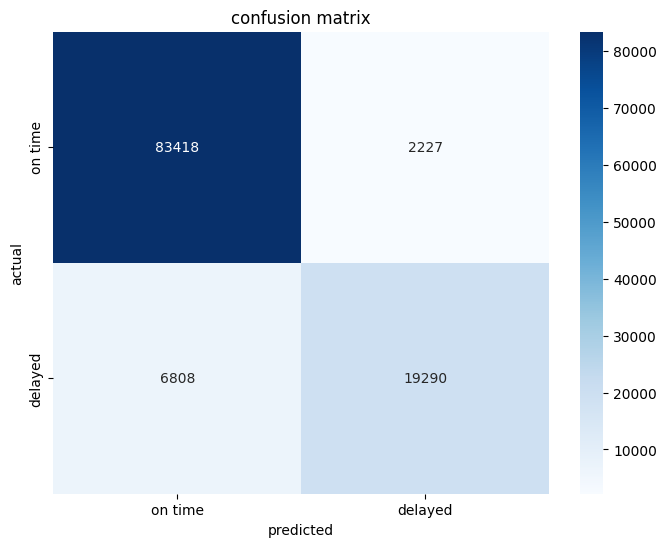

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['on time', 'delayed'],
            yticklabels=['on time', 'delayed'])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

class imbalance! notice the high accuracy but low recall, and how most of the datapoints in the confusion matrix is in the "on time" category. we'll attempt to address this class imbalance in this next section:

In [33]:
# penalize minority class misclassifications more
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [34]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")
report = classification_report(y_test, y_pred)
print("classification report:\n", report)

accuracy: 0.8989824865987132
classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     85645
           1       0.76      0.83      0.79     26098

    accuracy                           0.90    111743
   macro avg       0.85      0.87      0.86    111743
weighted avg       0.90      0.90      0.90    111743



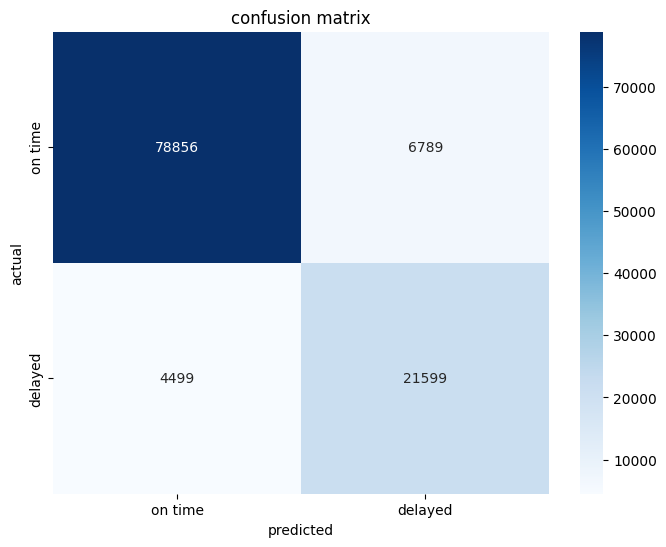

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['on time', 'delayed'],
            yticklabels=['on time', 'delayed'])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()